In [3]:
import kaggle
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
import albumentations as A
import tensorflow as tf
import keras
import segmentation_models as sm
sm.set_framework('tf.keras')
from segmentation_models import Unet
from segmentation_models.metrics import FScore
from keras.optimizers import adam_v2
from keras.models import load_model

## Airbus Ship Detection 
### Import dataset from Kaggle

In [11]:
!mkdir -p ~/.kaggle
!echo '{"username":"input_your_username_here","key":"input_your_key here"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle competitions download -c airbus-ship-detection --force

100%|██████████████████████████████████████| 28.6G/28.6G [13:59<00:00, 23.1MB/s]
100%|██████████████████████████████████████| 28.6G/28.6G [13:59<00:00, 36.6MB/s]


In [6]:
fantasy_zip = zipfile.ZipFile('airbus-ship-detection.zip')
fantasy_zip.extractall()
fantasy_zip.close()

### Data preprocessing

In [60]:
masks = pd.read_csv('train_ship_segmentations_v2.csv')
masks.head(3)

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...


Dataframe include rows with filenames from 'train_v2' folder and rows with encoded pixels belong to mask for ships on the images.

##### See images

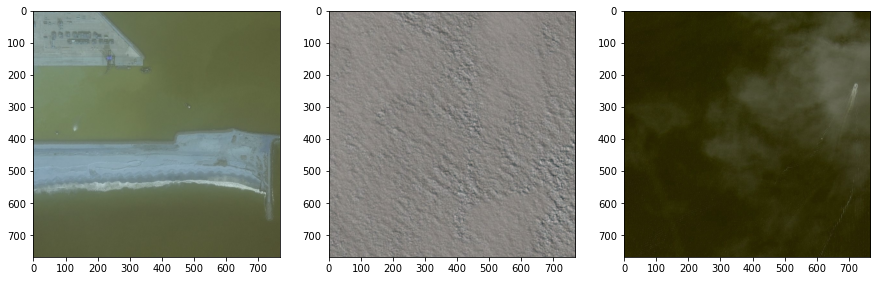

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
axes[0].imshow(cv2.imread('train_v2/'+ masks.iat[5,0]))
axes[1].imshow(cv2.imread('train_v2/'+ masks.iat[451,0]))
axes[2].imshow(cv2.imread('train_v2/'+ masks.iat[8061,0]))
plt.show()

In [4]:
print('Images shape is:', cv2.imread('train_v2/'+ masks.iat[5,0]).shape[:2])

Images shape is: (768, 768)


On the images coast, clouds, ships in any weather.

##### Images namber

In [5]:
len(masks)                                   

231723

##### Number of unique images

In [80]:
masks.groupby(['ImageId'])['ImageId'].count()

ImageId
00003e153.jpg    1
0001124c7.jpg    1
000155de5.jpg    1
000194a2d.jpg    5
0001b1832.jpg    1
                ..
fffedbb6b.jpg    1
ffff2aa57.jpg    1
ffff6e525.jpg    1
ffffc50b4.jpg    1
ffffe97f3.jpg    1
Name: ImageId, Length: 192556, dtype: int64

There are 230k rows in total, and 190k unique images. This means that there can be several masks for one image.

##### Number of ships (masks) in the image and how many such images

In [81]:
masks.groupby(['ImageId'])['ImageId'].count().value_counts()

1     177104
2       7674
3       2954
4       1622
5        925
6        657
7        406
8        318
9        243
10       168
11       144
12       124
14        76
13        75
15        66
Name: ImageId, dtype: int64

##### Number of images without ships 

In [4]:
masks.EncodedPixels.isna().sum()     

150000

For every ship in dataframe are personal mask.
A lot of images with more the one ship. For training will merge all the masks for each image.

A lot of empty images.

#### Remove images without ships

#### Split data to train, validation and test sets (70:28:2) (img with ships count)

In [71]:
train_df = masks[:220000]
test_df = masks[220000:]
test_df.reset_index(drop=True, inplace=True)


In [72]:
train_df = train_df.dropna(axis='index')    # images without ships don't need for train
train_df, val_df = train_test_split (train_df, test_size=0.3, random_state=42)
train_df.shape, val_df.shape, test_df.shape 

((54294, 2), (23269, 2), (11723, 2))

#### Function for decoding lables to masks

In [10]:
def rle_decode(mask_rle, shape=(768, 768)):            
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  

#### Function for augmentation images

In [11]:
transform = A.Compose([
    A.ShiftScaleRotate(shift_limit = 0.125, scale_limit=0.2, rotate_limit = 10, p = 0.7, border_mode = cv2.BORDER_CONSTANT),
    A.RandomCrop(256, 256),
    A.RandomRotate90(p = .2),
    A.ElasticTransform(1., p = .2),
    A.HorizontalFlip(p = .2),
    A.OneOf([A.RandomCrop(256, 256),
            A.GaussNoise( ),
            ], p = 0.3),
    A.OneOf([  A.RandomCrop(256, 256),
            A.MotionBlur(p = .4),
            A.Blur(blur_limit = 3, p = 0.3),
        ], p = 0.5),
        A.OneOf([ A.RandomCrop(256, 256),
            A.OpticalDistortion(p = 0.3),
            A.GridDistortion(p = 0.1),
            A.PiecewiseAffine(p = 0.3),
        ], p = 0.5),
        A.OneOf([ A.RandomCrop(256, 256),
            A.CLAHE(clip_limit = 3),
            A.Sharpen(),
            A.Emboss(),
            
        ], p = 0.4),
], p = 1)

#### Generators for Model training (to reduce memory usage)

In [12]:
def img_generator(gen_df, batch_size):                      # Generator 'img + mask' for model fitting (to reduce memory usage)
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):
            img_name, mask_rle = gen_df.sample(1).values[0]                                 # get row from DF
            img = cv2.imread('train_v2/'+ img_name)                                         # read img
            
            img_masks = masks.loc[masks['ImageId'] == img_name, 'EncodedPixels'].tolist()   # find all ship masks for image with more the one ship                                          
            all_masks = np.zeros((768, 768))                                                # create a single mask array for all ships
            for mask in img_masks:
                all_masks += rle_decode(mask)
            
            transformed = transform(image = img, mask = all_masks)                          # augm. data crop, rotate ect.
            image_transformed = transformed['image']
            mask_transformed = transformed['mask']
            
            x_batch += [image_transformed]                                                  # put into batch
            y_batch += [mask_transformed]

        x_batch = np.array(x_batch) / 255.                                                  # reduce color dimension img
        y_batch = np.array(y_batch)

        yield x_batch, np.expand_dims(y_batch, -1)                                          # return batch

#### How generators, augmentation and decoding works

In [14]:
for x, y in img_generator(train_df, 16):                                                 
    break
x.shape, y.shape                            # output shapes

((16, 256, 256, 3), (16, 256, 256, 1))

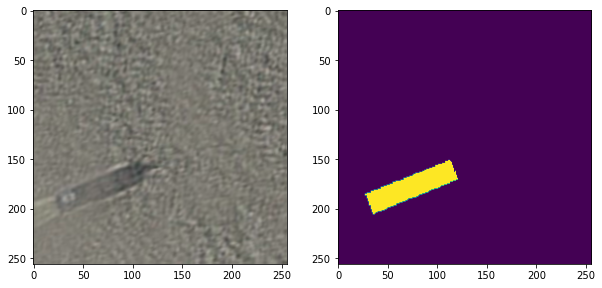

In [58]:
transformed = transform(image=x[5], mask=y[5])

image_transformed = transformed['image']
mask_transformed = transformed['mask']

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].imshow(image_transformed)
axes[1].imshow(mask_transformed[:,:,0])

plt.show()

### Make the Model

In [17]:
model = Unet(backbone_name='resnet34',
             input_shape=(256, 256, 3),
             classes=1,
             encoder_weights='imagenet',
             encoder_freeze=True,
             activation='sigmoid' )

In [18]:
best_w = keras.callbacks.ModelCheckpoint('r34_best.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('r34_last.h5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                period=1)


callbacks = [best_w, last_w]

adam = tf.keras.optimizers.Adam(learning_rate=0.0001,
                                beta_1=0.9,
                                beta_2=0.999,
                                epsilon=1e-08,
                                decay=0.0)

metric = FScore()

model.compile(adam, 'binary_crossentropy', [metric])

#### Fit the Model

In [ ]:
batch_size = 16

history = model.fit(img_generator(train_df, batch_size),
              steps_per_epoch=100,
              epochs=100,
              verbose=1,
              callbacks=callbacks,
              validation_data=img_generator(val_df, batch_size),
              validation_steps=10,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

Epoch 1/100
100/100 [==============================] - 750s 7s/step - loss: 0.5001 - f1-score: 0.0146 - val_loss: 0.5148 - val_f1-score: 0.0019
Epoch 2/100
 11/100 [==>...........................] - ETA: 10:29 - loss: 0.3355 - f1-score: 0.0153

### Assessment
#### How the Model was lerned

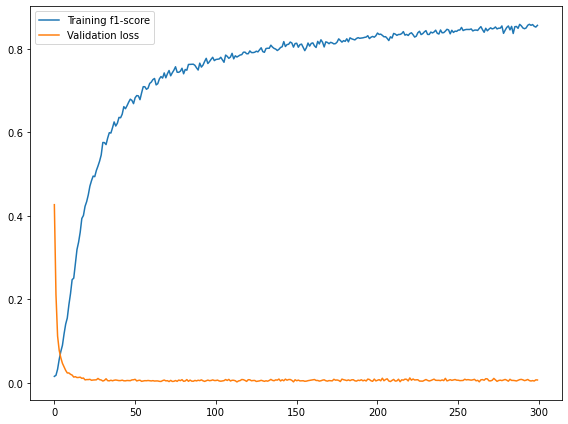

In [45]:
model_history = pd.DataFrame(history.history)
model_history['epoch'] = history.epoch

fig, ax = plt.subplots(1, figsize=(8,6))
num_epochs = history.shape[0]

ax.plot(np.arange(0, num_epochs), history["f1-score"], 
        label="Training f1-score")
ax.plot(np.arange(0, num_epochs), history["val_loss"], 
        label="Validation loss")
ax.legend()

plt.tight_layout()
plt.show()

The graph of the f1-score continues to grow, the model can continue to be trained.

#### What model is predict

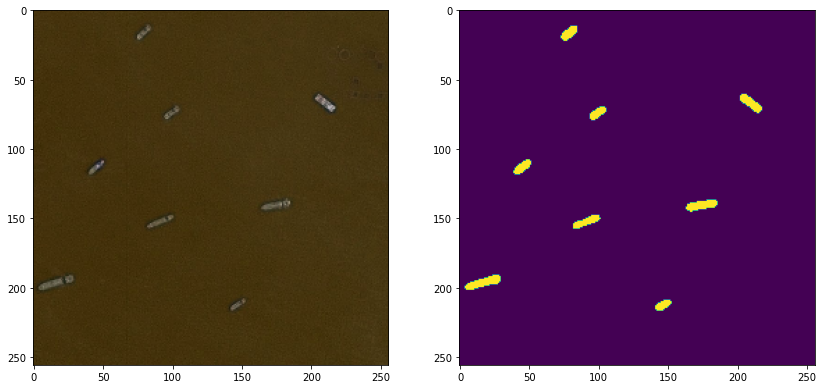

In [109]:
for x, y in img_generator_test(test_df, len(test_df)):      
    break
y = np.float32(y)
pred = model.predict(x)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].imshow(x[4])
axes[1].imshow(pred[4, ..., 0]>0.5 )

plt.show()

#### The Model Metrics

In [48]:
print('Coef MeanIoU: ', tf.keras.metrics.MeanIoU(num_classes=2)(y, pred))
print('The F-score (Dice coefficient): ', FScore()(y, pred))

Coef MeanIoU:  tf.Tensor(0.49814662, shape=(), dtype=float32)
The F-score (Dice coefficient):  tf.Tensor(0.5206917, shape=(), dtype=float32)


### Save the Model

In [100]:
model.save('saved_model.h5')